In [2]:
import torch
import pandas as pd
from pathlib import Path
from transformers import AutoModel

from src.tokenizer import PolyBertTokenizer
from src.modelv4 import ConditionalVAESmiles

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = Path("checkpoints/finetune_tg_modelv4.pt") # 加载模型权重
ckpt = torch.load(ckpt_path, map_location=device)

tokenizer = PolyBertTokenizer("./polybert") # 加载分词器
polybert = AutoModel.from_pretrained("./polybert").to(device) 

model_kwargs = ckpt["model_kwargs"].copy()
model_kwargs.update({
    "vocab_size": tokenizer.vocab_size,
    "polybert": polybert,
    "use_polybert": True,
})
model = ConditionalVAESmiles(**model_kwargs).to(device)
model.load_state_dict(ckpt["model"])
model.eval()

tg_stats = ckpt["tg_stats"]
df = pd.read_csv("data/PSMILES_Tg_only.csv")

/var/folders/zp/7_rwy7bn2vgckz6rtnz6fvp00000gn/T/ipykernel_61719/3318042044.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=de

In [3]:
from src.dataset_tg import make_loader_with_tg, TgStats 

tg_stats_obj = TgStats(**tg_stats) # 标准化Tg
val_loader, _ = make_loader_with_tg( # 创建数据加载器
    df,
    tokenizer,
    batch_size=32,
    shuffle=False,
    col_smiles="PSMILES",
    col_tg="Tg",
    max_len=256,
    tg_stats=tg_stats_obj,
)


In [4]:
import numpy as np

all_mu, all_logvar, all_tg = [], [], [] # 存储潜在变量和Tg值

with torch.no_grad():
    for batch in val_loader:
        print(f"Processing batch {len(all_mu)} / {len(val_loader)}", end="\r")
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        tg_cond = batch["tg"].to(device).unsqueeze(-1)
        mu, logvar = model.encode(input_ids, attention_mask)
        all_mu.append(mu.cpu())
        all_logvar.append(logvar.cpu())
        all_tg.append((tg_cond.squeeze(-1).cpu().numpy() * tg_stats_obj.std) + tg_stats_obj.mean)

all_mu = torch.cat(all_mu).numpy()
all_logvar = torch.cat(all_logvar).numpy()
all_tg = np.concatenate(all_tg)


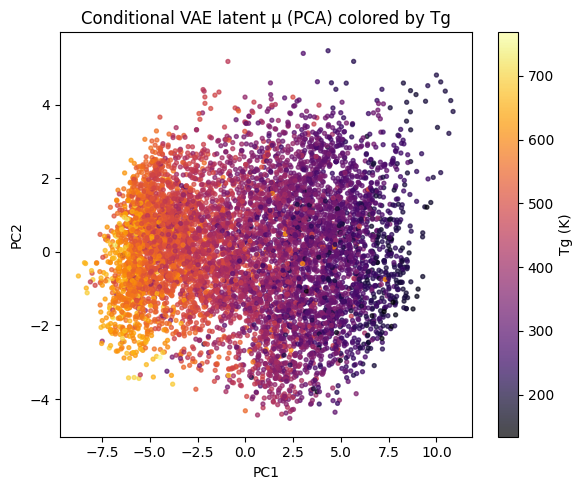

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
mu_2d = pca.fit_transform(all_mu)
# PCA可视化潜空间
plt.figure(figsize=(6, 5))
sc = plt.scatter(mu_2d[:, 0], mu_2d[:, 1], c=all_tg, cmap="inferno", s=8, alpha=0.7)
plt.colorbar(sc, label="Tg (K)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Conditional VAE latent μ (PCA) colored by Tg")
plt.tight_layout()
plt.show()


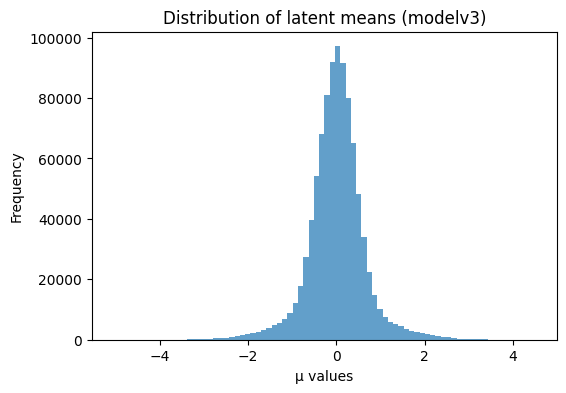

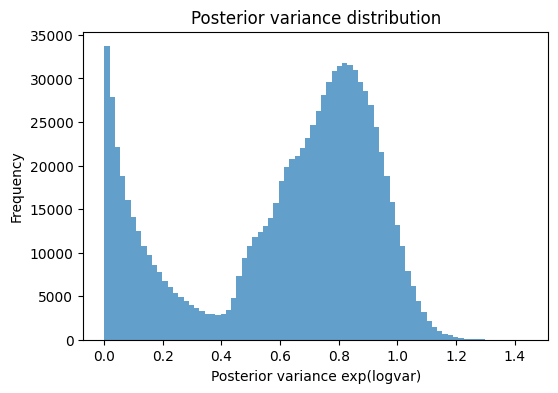

In [6]:
# 观察潜在变量的分布
plt.figure(figsize=(6, 4))
plt.hist(all_mu.reshape(-1), bins=80, alpha=0.7)
plt.xlabel("μ values")
plt.ylabel("Frequency")
plt.title("Distribution of latent means (modelv3)")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(np.exp(all_logvar).reshape(-1), bins=80, alpha=0.7)
plt.xlabel("Posterior variance exp(logvar)")
plt.ylabel("Frequency")
plt.title("Posterior variance distribution")
plt.show()


In [7]:
# 潜空间插值
def encode_conditional(smiles: str, target_tg: float):
    ids = tokenizer.encode(smiles)
    inp = torch.tensor(ids, device=device).unsqueeze(0)
    mask = (inp != tokenizer.pad_id).long()
    mu, _ = model.encode(inp, mask)
    norm_tg = (target_tg - tg_stats_obj.mean) / tg_stats_obj.std
    cond = torch.tensor([[norm_tg]], device=device, dtype=torch.float32)
    return mu.squeeze(0), cond.squeeze(0)

s1, s2 = df["PSMILES"].iloc[0], df["PSMILES"].iloc[100]
tg1, tg2 = df["Tg"].iloc[0], df["Tg"].iloc[100]
z1, cond1 = encode_conditional(s1, tg1)
z2, cond2 = encode_conditional(s2, tg2)

alphas = torch.linspace(0, 1, steps=6, device=device)
decoded = []
with torch.no_grad():
    for a in alphas:
        z = (1 - a) * z1 + a * z2
        cond = (1 - a) * cond1 + a * cond2
        samples = model.sample(num_samples=1, conditions=cond.unsqueeze(0), z_base=z.unsqueeze(0))
        decoded.append(tokenizer.decode(samples.squeeze(0).tolist(), skip_special_tokens=True))

for a, smi in zip(alphas.cpu().numpy(), decoded):
    print(f"α={a:.2f} → {smi}")


α=0.00 → [*]C#CC#C[SiH]c1cccc(C#N)c1[*]
α=0.20 → [*]C#Cc1cccc(C#Cc2ccc([SiH]([*])C)cc2)c1
α=0.40 → [*]C#Cc1ccc2ccc(C#N)cc2-c2ccc(C#Cc3cncc([*])s3)c1
α=0.60 → [*]Cc1ccc(OCc2ccc(-c3ccc(C#N)cc3)cc2)c([Se]=[*])c1
α=0.80 → [*]Cc1ccc(Oc2ccc(-c3ccc(C#Cc4nnc([*])o4)cc3)nc2-c2ccccc2)cc1
α=1.00 → [*]Cc1ccc(-c2ccc(Oc3ccc(-n4on4-c5ccc(Oc6ccc(C=[*])cc6)cc5)cc4)cc3)cc2)nc1


In [8]:
# 条件采样与指标
from rdkit import Chem

def to_rdkit(smiles):
    return Chem.MolFromSmiles(smiles.replace("[*]", "[Xe]"))

@torch.no_grad()
def sample_with_target(target_tg: float, num=100):
    norm = (target_tg - tg_stats_obj.mean) / tg_stats_obj.std
    cond = torch.full((num, 1), norm, dtype=torch.float32, device=device)
    samples = model.sample(num_samples=num, conditions=cond, max_len=256)
    return [tokenizer.decode(row.tolist(), skip_special_tokens=True) for row in samples.cpu()]

generated = sample_with_target(target_tg=400, num=100)
valid = [s for s in generated if to_rdkit(s)]
validity = len(valid) / len(generated)
uniqueness = len(set(generated)) / len(generated)
train_set = set(df["PSMILES"].astype(str))
novelty = len([s for s in set(generated) if s not in train_set]) / max(len(set(generated)), 1)

print(f"(Tg≈400K) Validity={validity:.3f}, Uniqueness={uniqueness:.3f}, Novelty={novelty:.3f}")


(Tg≈400K) Validity=0.470, Uniqueness=1.000, Novelty=1.000


[13:50:18] Can't kekulize mol.  Unkekulized atoms: 7 35 36
[13:50:18] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 43 44
[13:50:18] SMILES Parse Error: unclosed ring for input: '[Xe]Nc1cc(CC([Xe])(C)C)ccc1-c1cc(OC(=O)c3ccc([N+](=O)[O-])cc2)cc(CCCC)c1'
[13:50:18] SMILES Parse Error: unclosed ring for input: '[Xe]Oc1ccc2c(c1)C([Si](C)(CC)N1C(=O)C(C([Xe])=O)c3ccccc3c2)C(=O)N2'
[13:50:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 23 26
[13:50:18] SMILES Parse Error: extra close parentheses while parsing: [Xe]Oc1ccc(C(=[Xe])CCCC)c(S(=O)(=O)c2ccc(OCN3)cc2)c2ccc(C2=O)cc2)c1
[13:50:18] SMILES Parse Error: Failed parsing SMILES '[Xe]Oc1ccc(C(=[Xe])CCCC)c(S(=O)(=O)c2ccc(OCN3)cc2)c2ccc(C2=O)cc2)c1' for input: '[Xe]Oc1ccc(C(=[Xe])CCCC)c(S(=O)(=O)c2ccc(OCN3)cc2)c2ccc(C2=O)cc2)c1'
[13:50:18] SMILES Parse Error: ring closure 2 duplicates bond between atom 23 and atom 24 for input: '[Xe]CC(=O)Oc1ccc(C2CCCCN([Xe])Cc2ccc(Cl)nc2-c2ccccc2)cc1'
[13:50:18] SMILES Parse Error: unclosed ring for 